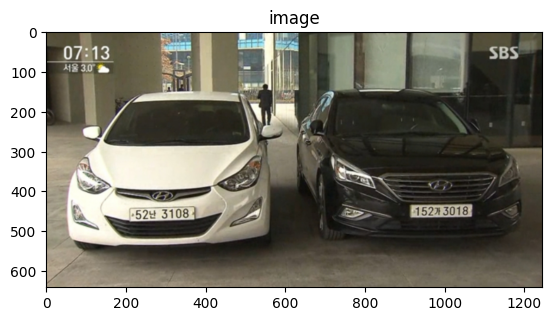

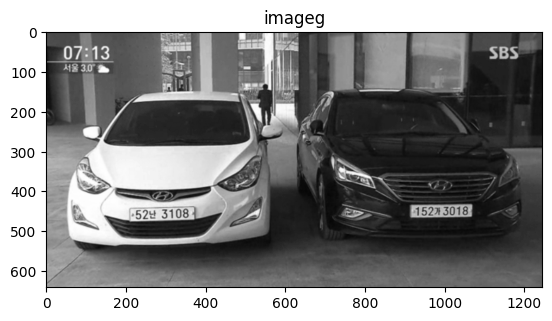

In [64]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

image_path = './data/hyeonju.png'

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('image')
plt.show()

imageg = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(imageg, 'gray')
plt.title('imageg')
plt.show()

grayscale + tophat - blackhat ==> 선명해짐

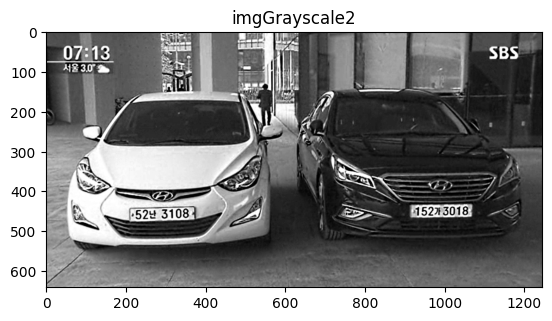

In [65]:
se = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

imgTophat = cv2.morphologyEx(imageg, cv2.MORPH_TOPHAT, se)
imgBlackhat = cv2.morphologyEx(imageg, cv2.MORPH_BLACKHAT, se)

imgGrayscalePlusTophat = cv2.add(imageg, imgTophat)

imgGrayscale2 = cv2.subtract(imgGrayscalePlusTophat, imgBlackhat)

plt.imshow(imgGrayscale2, 'gray')
plt.title('imgGrayscale2')
plt.show()

blur -> adaptive threshold ==> 윤곽선?

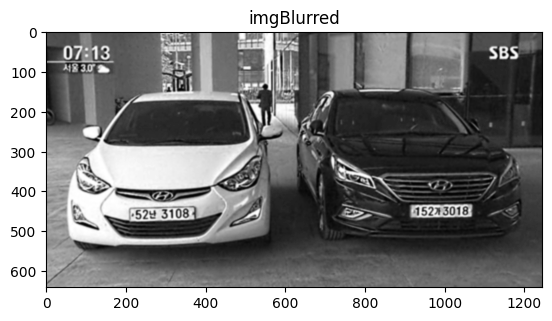

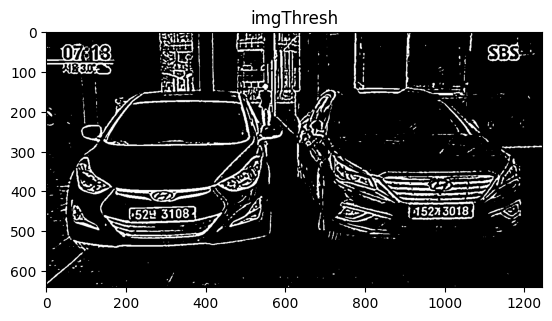

In [66]:
imgBlurred = cv2.GaussianBlur(imgGrayscale2, ksize = (7, 7), sigmaX = 0)

plt.imshow(imgBlurred, 'gray')
plt.title('imgBlurred')
plt.show()

imgThresh = cv2.adaptiveThreshold(
    imgBlurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=15,
    C=9
)

plt.imshow(imgThresh, 'gray')
plt.title('imgThresh')
plt.show()

drawContours

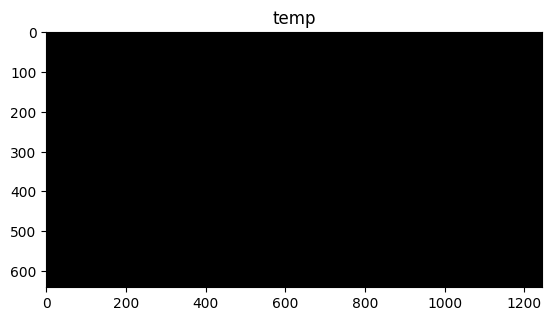

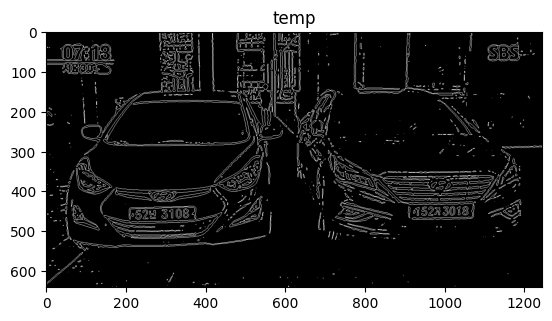

In [67]:
contours, hierarchy = cv2.findContours(
    imgThresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

height, width, channel = image.shape
temp = np.zeros((height, width, channel), dtype = np.uint8)

plt.imshow(temp, 'gray')
plt.title('temp')
plt.show()

cv2.drawContours(temp, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.imshow(temp, 'gray')
plt.title('temp')
plt.show()

In [68]:
print(contours)
print(len(contours))
print('--------------------------------------')
print(hierarchy)
print(hierarchy.shape)

(array([[[176, 640]],

       [[177, 640]]], dtype=int32), array([[[167, 640]]], dtype=int32), array([[[1026,  638]],

       [[1027,  638]]], dtype=int32), array([[[608, 638]],

       [[608, 640]],

       [[609, 640]],

       [[609, 638]]], dtype=int32), array([[[304, 636]]], dtype=int32), array([[[393, 634]],

       [[393, 635]],

       [[394, 635]],

       [[394, 634]]], dtype=int32), array([[[433, 632]]], dtype=int32), array([[[424, 632]],

       [[423, 633]],

       [[424, 634]],

       [[426, 634]]], dtype=int32), array([[[402, 631]],

       [[398, 635]],

       [[398, 636]],

       [[399, 636]],

       [[403, 632]],

       [[406, 632]],

       [[407, 633]],

       [[408, 633]],

       [[407, 632]],

       [[406, 632]],

       [[405, 631]]], dtype=int32), array([[[139, 631]],

       [[138, 632]],

       [[140, 632]],

       [[141, 631]]], dtype=int32), array([[[127, 631]],

       [[126, 632]],

       [[126, 633]],

       [[129, 633]],

       [[129, 631]]

============================================================================

모든 contour에 대한 rectangle 그리고, contours_dict 구성하기

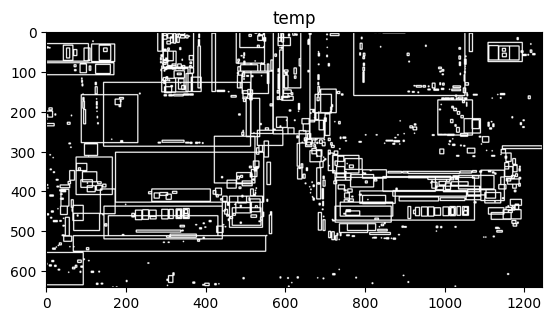

In [69]:
temp = np.zeros((height, width, channel), dtype = np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w/2),
        'cy': y + (h/2)
    })
    
plt.imshow(temp, 'gray')
plt.title('temp')
plt.show()

In [70]:
print(contours_dict)
print(len(contours_dict))

[{'contour': array([[[176, 640]],

       [[177, 640]]], dtype=int32), 'x': 176, 'y': 640, 'w': 2, 'h': 1, 'cx': 177.0, 'cy': 640.5}, {'contour': array([[[167, 640]]], dtype=int32), 'x': 167, 'y': 640, 'w': 1, 'h': 1, 'cx': 167.5, 'cy': 640.5}, {'contour': array([[[1026,  638]],

       [[1027,  638]]], dtype=int32), 'x': 1026, 'y': 638, 'w': 2, 'h': 1, 'cx': 1027.0, 'cy': 638.5}, {'contour': array([[[608, 638]],

       [[608, 640]],

       [[609, 640]],

       [[609, 638]]], dtype=int32), 'x': 608, 'y': 638, 'w': 2, 'h': 3, 'cx': 609.0, 'cy': 639.5}, {'contour': array([[[304, 636]]], dtype=int32), 'x': 304, 'y': 636, 'w': 1, 'h': 1, 'cx': 304.5, 'cy': 636.5}, {'contour': array([[[393, 634]],

       [[393, 635]],

       [[394, 635]],

       [[394, 634]]], dtype=int32), 'x': 393, 'y': 634, 'w': 2, 'h': 2, 'cx': 394.0, 'cy': 635.0}, {'contour': array([[[433, 632]]], dtype=int32), 'x': 433, 'y': 632, 'w': 1, 'h': 1, 'cx': 433.5, 'cy': 632.5}, {'contour': array([[[424, 632]],

      

조건을 만족하는 (최소 면적, 너비, 높이 초과이며 최소/최대 종횡비 내) contour에 대해서만 rectangle 그리기

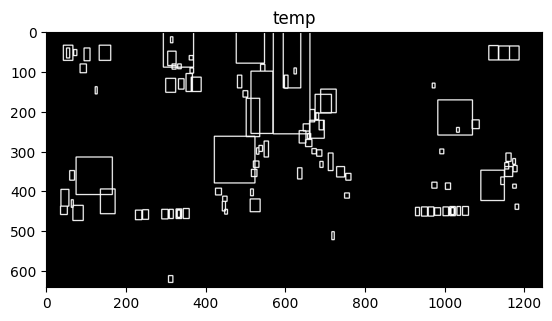

In [71]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

num = 0

for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = num
        num += 1
        possible_contours.append(d)
    
temp = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours:
    cv2.rectangle(temp, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
plt.imshow(temp, 'gray')
plt.title('temp')
plt.show()

서로 match가 될만한 contour들을 모으는 함수 정의

In [72]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 4

def find_chars(contours_list):
    matched_result_idx = []
    
    for d1 in contours_list:
        print("\nd1['idx']:\n", d1['idx'])
        
        # 한 d1에 대해, 이와 match되는 d2들을 matched_contours_idx에 담고 마지막에 d1 본인을 담기
        
        matched_contours_idx = []
        
        for d2 in contours_list:
            print("d2['idx']:\n", d2['idx'])
            
            if d1['idx'] == d2['idx']:
                continue
            
            # filtering에 필요한 변수들 정의
            
            diag1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
                
            area_diff =abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            # 조건들에 맞는 것만 filtering하여 matched_contours_idx에 append
            
            if distance < diag1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF \
            and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
        
        matched_contours_idx.append(d1['idx'])
        
        print("\nmatched_contours_idx:\n", matched_contours_idx)
        
        # 만약 match된 개수가 MIN_N_MATCHED보다 작으면, matched_result_idx에 모으지 말고 그냥 넘어가기 (3개는 돼야지!)
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        
        # 이렇게, 해당 d1이 다른 모든 d2들과 비교되며 match가 완료된 matched_contours_idx를 matched_result_idx에 추가
        
        matched_result_idx.append(matched_contours_idx)
        
        print("\nmatched_result_idx:\n", matched_result_idx)
        
        # 아직 match되지 않은 idx들의 contour에 대해서도 다시 match 시도
        
        unmatched_contours_idx = []
        
        for d0 in contours_list:
            if d0['idx'] not in matched_contours_idx:
                unmatched_contours_idx.append(d0['idx'])
                
        unmatched_contours_list = np.take(possible_contours, unmatched_contours_idx) 
        # 이때 possible_contours가 아니라 contours_list를 넣으면, 재귀가 반복되면서 점점 크기가 작아져, 두번째 인수로써 인덱싱이 불가능해지므로, possible_contours를 넣어야 함
        
        rematched_result_idx = find_chars(unmatched_contours_list)
        
        for idx in rematched_result_idx:
            matched_result_idx.append(idx)
            
        print("\nmatched_result_idx:\n", matched_result_idx)
            
        break
    
    print("\nmatched_result_idx:\n", matched_result_idx)
    
    return matched_result_idx

possible_contours에 find_chars 함수 적용함으로써 match되는 contour들 찾고 이에 대한 rectangular 그리기


d1['idx']:
 0
d2['idx']:
 0
d2['idx']:
 1
d2['idx']:
 2
d2['idx']:
 3
d2['idx']:
 4
d2['idx']:
 5
d2['idx']:
 6
d2['idx']:
 7
d2['idx']:
 8
d2['idx']:
 9
d2['idx']:
 10
d2['idx']:
 11
d2['idx']:
 12
d2['idx']:
 13
d2['idx']:
 14
d2['idx']:
 15
d2['idx']:
 16
d2['idx']:
 17
d2['idx']:
 18
d2['idx']:
 19
d2['idx']:
 20
d2['idx']:
 21
d2['idx']:
 22
d2['idx']:
 23
d2['idx']:
 24
d2['idx']:
 25
d2['idx']:
 26
d2['idx']:
 27
d2['idx']:
 28
d2['idx']:
 29
d2['idx']:
 30
d2['idx']:
 31
d2['idx']:
 32
d2['idx']:
 33
d2['idx']:
 34
d2['idx']:
 35
d2['idx']:
 36
d2['idx']:
 37
d2['idx']:
 38
d2['idx']:
 39
d2['idx']:
 40
d2['idx']:
 41
d2['idx']:
 42
d2['idx']:
 43
d2['idx']:
 44
d2['idx']:
 45
d2['idx']:
 46
d2['idx']:
 47
d2['idx']:
 48
d2['idx']:
 49
d2['idx']:
 50
d2['idx']:
 51
d2['idx']:
 52
d2['idx']:
 53
d2['idx']:
 54
d2['idx']:
 55
d2['idx']:
 56
d2['idx']:
 57
d2['idx']:
 58
d2['idx']:
 59
d2['idx']:
 60
d2['idx']:
 61
d2['idx']:
 62
d2['idx']:
 63
d2['idx']:
 64
d2['idx']:
 65
d2['i

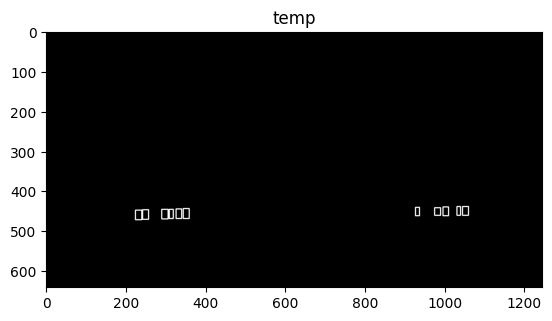

In [73]:
# possible_contours에 find_chars 적용하면, 서로 match되는 contour들의 index 묶음(들)이 result_idx 안에 들어있음

result_idx = find_chars(possible_contours)

# 그 index들에 해당하는 contour들의 dictionary 묶음(들)을 result에 저장 

result = []
for idx_list in result_idx:
    result.append(np.take(possible_contours, idx_list))

# contour들에 대해 rectangular 그리기
    
temp = np.zeros((height, width, channel), dtype = np.uint8)

for r in result:
    for d in r:
        cv2.rectangle(temp, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
        
plt.imshow(temp, 'gray')
plt.title('temp')
plt.show()  

============================================================================

plate 부분만 잘라내기


i:
 0

matched_chars:
 [{'contour': array([[[248, 447]],

        [[247, 448]],

        [[246, 448]],

        [[245, 449]],

        [[244, 449]],

        [[243, 450]],

        [[243, 451]],

        [[242, 452]],

        [[242, 453]],

        [[244, 455]],

        [[246, 453]],

        [[246, 452]],

        [[248, 450]],

        [[250, 450]],

        [[252, 452]],

        [[252, 456]],

        [[249, 459]],

        [[249, 460]],

        [[247, 462]],

        [[247, 463]],

        [[245, 465]],

        [[245, 466]],

        [[243, 468]],

        [[243, 469]],

        [[244, 470]],

        [[255, 470]],

        [[256, 469]],

        [[256, 468]],

        [[255, 468]],

        [[254, 467]],

        [[253, 467]],

        [[252, 468]],

        [[250, 468]],

        [[248, 466]],

        [[249, 465]],

        [[249, 464]],

        [[253, 460]],

        [[253, 459]],

        [[254, 458]],

        [[254, 457]],

        [[255, 456]],

        [[255, 450]],

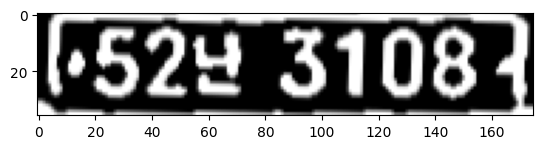


i:
 1

matched_chars:
 [{'contour': array([[[933, 441]],

        [[931, 443]],

        [[929, 443]],

        [[928, 444]],

        [[927, 444]],

        [[927, 445]],

        [[928, 446]],

        [[930, 446]],

        [[932, 448]],

        [[932, 455]],

        [[931, 456]],

        [[931, 461]],

        [[935, 461]],

        [[935, 447]],

        [[936, 446]],

        [[936, 441]]], dtype=int32), 'x': 927, 'y': 441, 'w': 10, 'h': 21, 'cx': 932.0, 'cy': 451.5, 'idx': 12}
 {'contour': array([[[ 998,  440]],

        [[ 997,  441]],

        [[ 997,  442]],

        [[ 998,  443]],

        [[1001,  443]],

        [[1002,  442]],

        [[1003,  443]],

        [[1004,  443]],

        [[1005,  444]],

        [[1005,  445]],

        [[1001,  449]],

        [[1002,  450]],

        [[1005,  450]],

        [[1006,  451]],

        [[1006,  452]],

        [[1007,  453]],

        [[1007,  455]],

        [[1006,  456]],

        [[1006,  457]],

        [[1005,  458

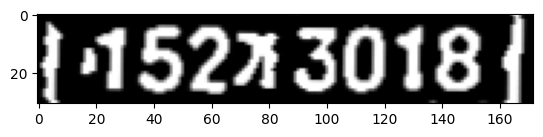

In [74]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(result): # enumerate 한번밖에 안돌음
    print("\ni:\n", i)
    print("\nmatched_chars:\n", matched_chars)
    
    # sorting
    
    sorted_chars = sorted(matched_chars, key = lambda x: x['cx'])
    
    # plate의 center x, center y, width, height 계산
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2 
    
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        print("\nd:\n", d)
        print("\nd['h']:\n", d['h'])
        sum_height += d['h']
        print("\nsum_height:\n", sum_height)
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # image rotation
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenuse = np.linalg.norm(
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']]) 
        - np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']])
    )
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenuse))
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(imgThresh, M=rotation_matrix, dsize=(width, height))
    
    # image crop
    
    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )
    
    # plate_imgs, plate_infos에 append
    
    plate_imgs.append(img_cropped)
    
    plate_infos.append({
        'x': int(plate_cx - plate_width/2),
        'y': int(plate_cy - plate_height/2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.imshow(img_cropped, 'gray')
    plt.show()

글자 부분만 추출하기

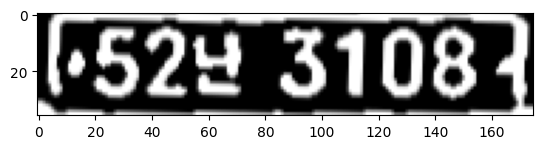

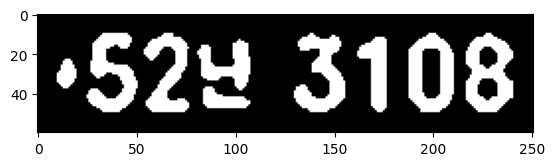

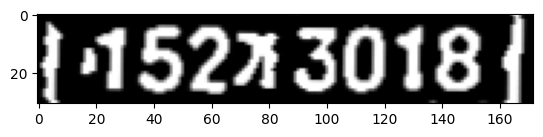

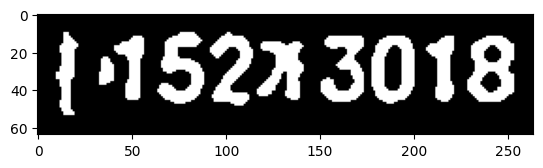

In [75]:
# plate image 하나씩에 대해서

for i, plate_img in enumerate(plate_imgs): # enumerate 한번밖에 안돌음
    plt.imshow(plate_img, 'gray')
    plt.show()
    
    # resize, threshold
    
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)

    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # plate_min_x, plate_min_y, plate_max_x, plate_max_y 구하기
    
    contours, hierarchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE) # contours: tuple type, len(contours) = 15
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h
        
        # 조건을 만족하는 contour에 대해서만 고려하기
        
        if area > MIN_AREA \
            and w > MIN_WIDTH and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h
                    
    # image crop, Gaussian blurring, Thresholding, 테두리 여유분 생성
        
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    plt.imshow(img_result, 'gray')
    plt.show()

원본 image 위에 plate 부분 표시하기

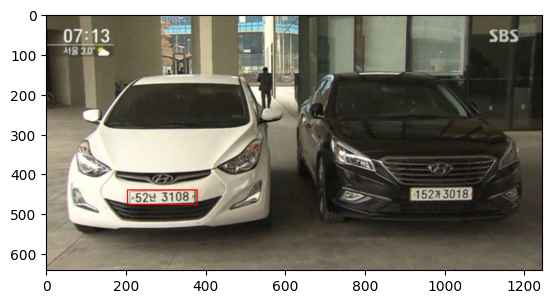

In [76]:
info = plate_infos[0]
image_copy = image.copy()

cv2.rectangle(image_copy, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color = (255,0,0), thickness=2)

plt.imshow(image_copy)
plt.show()